# **Import Parameters**

In [1]:
# Modules
import geemap
import ee
import numpy
import matplotlib.pyplot as plt
import folium
import IPython.display as disp

In [2]:
# Initiate the library
ee.Initialize()

In [3]:
# Authenticate Earth Engine
ee.Authenticate()

True

In [4]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [5]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              130.90080779641522,
              -12.506544445458758
            ],
            [
              130.90080779641522,
              -12.53914682181454
            ],
            [
              130.936907602198,
              -12.53914682181454
            ],
            [
              130.936907602198,
              -12.506544445458758
            ],
            [
              130.90080779641522,
              -12.506544445458758
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [6]:
coords = geoJSON['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

In [7]:
#Region = ee.Geometry.Rectangle(114.954250, -21.665954, 115.049694, -21.732942)
# 116.782751, -20.582106, 116.759662, -20.599863 # Karratha
# 114.954250, -21.665954, 115.049694, -21.732942 # Chevron
# 130.930221, -12.503906, 130.878643, -12.576560 # Darwin
# Define date range
start_date = '2023-10-26'
end_date = '2023-10-27'

In [8]:
def get_least_cloudy_image(AOI, start_date, end_date, max_cloud_percentage=20):
    return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterBounds(AOI)
                    .filterDate(ee.Date(start_date), ee.Date(end_date))
                    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percentage))
                    .first()
                    .clip(AOI))

In [9]:
S2_L1C = get_least_cloudy_image(AOI, start_date, end_date)

In [10]:
S2_L1C.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60']

In [11]:
url = S2_L1C.select('B11').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

##### Band ratio

In [12]:
# Calculate the centroid of the region
ROI = AOI.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (B12,B11,B11/B12).
rgb = ee.Image.rgb(S2_L1C.select('B12'),
                   S2_L1C.select('B11'),
                   S2_L1C.select('B11').divide(S2_L1C.select('B12')))

# Create the map object.
m = folium.Map(location=ROI, zoom_start=13)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)
print('roi',ROI)

roi [-12.522845892065048, 130.918857699303]


# **Cloud Masking**

In [13]:
# Date Validate
#Start_Date = '2023-10-26'
#End_Date = '2023-10-27'

In [14]:
# Cloud masking
#CLOUD_FILTER = 20 # Defined above
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [15]:
def Get_S2_SR_Cloud_Col(Region, start_date, end_date):
    # Import and filter S2 SR.
    S2_SR = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(AOI)
        .filterDate(start_date, end_date)) # Use the one from above

    # Import and filter s2cloudless.
    S2_Cloudless = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2_SR,
        'secondary': S2_Cloudless,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [16]:
S2_SR_Cloud_Col_Eval = Get_S2_SR_Cloud_Col(AOI, start_date, end_date)

In [17]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [18]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [19]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [20]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [21]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

In [22]:
S2_SR_Cloud_Col_Eval_Disp = S2_SR_Cloud_Col_Eval.map(add_cld_shdw_mask)

display_cloud_layers(S2_SR_Cloud_Col_Eval_Disp)

## **Mask Removal**

In [23]:
#Region = ee.Geometry.Rectangle(130.9825040586519,-12.591236530819916, 130.80603616314409,-12.482652274143653)
#START_DATE = '2023-10-26'
#END_DATE = '2023-10-27'
#CLOUD_FILTER = 60
#CLD_PRB_THRESH = 40
#NIR_DRK_THRESH = 0.15
#CLD_PRJ_DIST = 2
#BUFFER = 100

In [24]:
S2_SR_Cloud_Col = Get_S2_SR_Cloud_Col(AOI, start_date, end_date) 

In [25]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [26]:
S2_SR_Median = (S2_SR_Cloud_Col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

In [27]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(S2_SR_Median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

# **Atmospheric Correction**

In [28]:
#https://github.com/ridhodwid/gee-atmcorr-S2/blob/kaggle-usage/bin/atmospheric.py

import requests

url = "https://github.com/ridhodwid/gee-atmcorr-S2/blob/kaggle-usage/bin/atmospheric.py"
response = requests.get(url)

with open("filename", "wb") as file:
    file.write(response.content)

In [29]:
# Clone the repository
!git clone https://github.com/ridhodwid/gee-atmcorr-S2.git

# Move to the repository directory
%cd gee-atmcorr-S2

# Import the module
from bin.atmospheric import Atmospheric

fatal: destination path 'gee-atmcorr-S2' already exists and is not an empty directory.
/home/hareeshrao/Methane/gee-atmcorr-S2


In [30]:
# Import Modules

from Py6S import *
import datetime
import math
import os
import sys
sys.path.append('/content/drive/MyDrive/')
#from atmospheric import Atmospheric

In [31]:
SixS

Py6S.sixs.SixS

In [32]:
# Mark the Region of Interest
Region= ee.Geometry.Rectangle(130.930221, -12.503906, 130.878643, -12.576560)

In [33]:
# The first Sentinel 2 image
S2_TOA = ee.Image(
  ee.ImageCollection('COPERNICUS/S2')
    .filterBounds(AOI)
    .filterDate(start_date, end_date)
    .sort('CLOUDY_PIXEL_PERCENTAGE')
    .first()
  )

# top of atmosphere reflectance
TOA = S2_SR_Median.divide(10000)
display(S2_TOA)

In [34]:
info = S2_TOA.getInfo()['properties']
scene_date = datetime.datetime.utcfromtimestamp(info['system:time_start']/1000)# i.e. Python uses seconds, EE uses milliseconds
solar_z = info['MEAN_SOLAR_ZENITH_ANGLE']
date = ee.Date(scene_date.strftime("%Y-%m-%d"))

In [35]:
h2o = Atmospheric.water(Region,date).getInfo()
o3 = Atmospheric.ozone(Region,date).getInfo()
aot = Atmospheric.aerosol(Region,date).getInfo()
display(h2o,o3,aot)

4.040000152587891

0.2671672794117647

0.218666672706604

In [36]:
# Calculate target altitude in km
SRTM = ee.Image('CGIAR/SRTM90_V4') # Shuttle Radar Topography mission covers *most* of the Earth
alt = SRTM.reduceRegion(reducer = ee.Reducer.mean(),geometry = Region.centroid()).get('elevation').getInfo()
km = alt/1000 # i.e. Py6S uses units of kilometers
display(SRTM,alt,km)

Name,Description
elevation,Elevation


6

0.006

In [37]:
# Instantiate
s = SixS()

# Atmospheric constituents
s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
s.aero_profile = AeroProfile.Continental
s.aot550 = aot

# Earth-Sun-satellite geometry
s.geometry = Geometry.User()
s.geometry.view_z = 0               # always NADIR (I think..)
s.geometry.solar_z = solar_z        # solar zenith angle
s.geometry.month = scene_date.month # month and day used for Earth-Sun distance
s.geometry.day = scene_date.day     # month and day used for Earth-Sun distance
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(km)

In [38]:
# Spectral Response Functions
# To obtain the spectral response fx of each band

def spectralResponseFunction(bandname):
    """
    Extract spectral response function for given band name
    """

    bandSelect = {
        'B1':PredefinedWavelengths.S2A_MSI_01,
        'B2':PredefinedWavelengths.S2A_MSI_02,
        'B3':PredefinedWavelengths.S2A_MSI_03,
        'B4':PredefinedWavelengths.S2A_MSI_04,
        'B5':PredefinedWavelengths.S2A_MSI_05,
        'B6':PredefinedWavelengths.S2A_MSI_06,
        'B7':PredefinedWavelengths.S2A_MSI_07,
        'B8':PredefinedWavelengths.S2A_MSI_08,
        'B8A':PredefinedWavelengths.S2A_MSI_8A,
        'B9':PredefinedWavelengths.S2A_MSI_09,
        'B10':PredefinedWavelengths.S2A_MSI_10,
        'B11':PredefinedWavelengths.S2A_MSI_11,
        'B12':PredefinedWavelengths.S2A_MSI_12,
        }

    return Wavelength(bandSelect[bandname])

In [39]:
# TOA Reflectance to Radiance
def TOA_to_rad(bandname):
    """
    Converts top of atmosphere reflectance to at-sensor radiance
    """

    # solar exoatmospheric spectral irradiance
    ESUN = info['SOLAR_IRRADIANCE_'+bandname]
    solar_angle_correction = math.cos(math.radians(solar_z))

    # Earth-Sun distance (from day of year)
    doy = scene_date.timetuple().tm_yday
    d = 1 - 0.01672 * math.cos(0.9856 * (doy-4)) # From http://physics.stackexchange.com/questions/177949/earth-sun-distance-on-a-given-day-of-the-year

    # conversion factor
    multiplier = ESUN*solar_angle_correction/(math.pi*d**2)

    # at-sensor radiance
    rad = TOA.select(bandname).multiply(multiplier)

    return rad

In [40]:
# Radiance to Surface Reflectance
def surface_reflectance(bandname):
    """
    Calculate surface reflectance from at-sensor radiance given waveband name
    """

    # run 6S for this waveband
    s.wavelength = spectralResponseFunction(bandname)
    s.run()

    # extract 6S outputs
    Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
    Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
    Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
    absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
    scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
    tau2 = absorb*scatter                                #total transmissivity

    # radiance to surface reflectance
    rad = TOA_to_rad(bandname)
    ref = rad.subtract(Lp).multiply(math.pi).divide(tau2*(Edir+Edif))

    return ref

In [41]:
# Use this if you only need surface reflectance of rgb channel
b = surface_reflectance('B8')
g = surface_reflectance('B11')
r = surface_reflectance('B12')
ref = r.addBands(g).addBands(b)

# Calculate surface reflectance for all wavebands
output = S2_TOA.select('QA60')
for band in ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']:
    print(band)
    band_reflectance = surface_reflectance(band)
    output = output.addBands(surface_reflectance(band))

B1
B2
B3
B4
B5
B6
B7
B8
B8A
B9
B10
B11
B12


In [42]:
# select band of interest
band11 = ref.select('B11')
band12 = ref.select('B12')

display(band11,band12)

In [43]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
S2_AC = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
S2_AC.add_ee_layer(band11,
                {'min': 0, 'max': 0.3, 'gamma': 3},
                'S2_Band11', True, 1, 9)

# Add layers to the folium map.
S2_AC.add_ee_layer(band12,
                {'min': 0, 'max': 0.3, 'gamma': 3},
                'S2_Band12',True, 1, 9)

# Add a layer control panel to the map.
S2_AC.add_child(folium.LayerControl())

# Display the map.
display(S2_AC)

## **Export File**

In [44]:
# Initiate the library
ee.Initialize()

In [45]:
# Authenticate Earth Engine
ee.Authenticate()

True

##### Export to GDrive

In [48]:
# Convert the folium map as an image
image = geemap.Map.to_image(S2_AC)

In [50]:
dateString = scene_date.strftime("%Y-%m-%d")
# Export the clipped image to Google Drive as a GeoTIFF file
export_params = {
    'image': S2_TOA.select(['B11', 'B12']),
    'description': 'Darwin_AC' +dateString,
    'folder': 'WA_Methane',
    'scale': 10,
    'region': AOI,
    'fileFormat': 'GeoTIFF',  # Specify the file format
}

# Export the image
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

In [51]:
# Print task status for debugging
print("Task Status:", task.status())

Task Status: {'state': 'RUNNING', 'description': 'Darwin_AC2023-10-26', 'creation_timestamp_ms': 1704734194293, 'update_timestamp_ms': 1704734202217, 'start_timestamp_ms': 1704734199633, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'PNBR5Y64HAHNDUO7Z3XREP3O', 'name': 'projects/earthengine-legacy/operations/PNBR5Y64HAHNDUO7Z3XREP3O'}


##### Export to GEE

In [52]:
# # set some properties for export
dateString = scene_date.strftime("%Y-%m-%d")
ref = ref.set({'satellite':'Sentinel 2',
              'fileID':info['system:index'],
              'date':dateString,
              'aerosol_optical_thickness':aot,
              'water_vapour':h2o,
              'ozone':o3})

In [53]:
# Define YOUR Google Earth Engine assetID
# in my case it was something like this..
assetID = 'users/Hareeshrao-LC60/Darwin_AC' +dateString
print('id',assetID)

id users/Hareeshrao-LC60/Darwin_AC2023-10-26


In [54]:
# Define the region using a polygon or coordinates
region = ee.Geometry.Polygon(
    [[
        [114.954250, -21.665954],
        [114.954250, -21.732942],
        [115.049694, -21.732942],
        [115.049694, -21.665954]
    ]])

# Export
export = ee.batch.Export.image.toAsset(\
    image=ref,
    description='sentinel2_atmcorr_export',
    assetId = assetID,
    region = AOI)

# uncomment to run the export
export.start()

# **Calculate Methane Concentration**

##### Methane Band

In [55]:
#import ee
#import geemap
#import folium


# Function to mask clouds using the Sentinel-2 QA band

# Function to calculate methane concentration from Sentinel-2 image
def calculate_methane_concentration(image):
    # Replace 'your_band_name' with the actual band containing atmospheric correction results
    methane_band = image.select('B12')
    # Specify the conversion factor if needed
    # methane_concentration = methane_band.multiply(CONVERSION_FACTOR)
    return methane_band

# Replace 'your_sentinel_image' with the actual Sentinel image
sentinel_image = ee.Image(S2_TOA)

# Apply atmospheric correction if needed
#atmospheric_corrected_image = sentinel_image.some_atmospheric_correction_function()

# Mask clouds
#masked_image = mask_clouds(atmospheric_corrected_image)

# Calculate methane concentration
methane_concentration_image = calculate_methane_concentration(sentinel_image)

# Display the methane concentration on the Folium map
Map = geemap.Map()
Map.centerObject(methane_concentration_image, zoom=10)
Map.addLayer(methane_concentration_image, {
    'bands': ['B12'],
    'min': 0,
    'max': 200  # Adjust the min and max values as needed
}, 'Methane Concentration')
Map.addLayerControl()
Map

# You can now visualize the methane concentration on the Folium map and further analyze the data.

Map(center=[-12.236992001490117, 131.3299936090307], controls=(WidgetControl(options=['position', 'transparent…

##### Methane Free Band

In [56]:
import ee
import geemap
import folium


# Function to mask clouds using the Sentinel-2 QA band

# Function to calculate methane concentration from Sentinel-2 image
def calculate_methane_concentration(image):
    # Replace 'your_band_name' with the actual band containing atmospheric correction results
    methane_band = image.select('B8')
    # Specify the conversion factor if needed
    # methane_concentration = methane_band.multiply(CONVERSION_FACTOR)
    return methane_band

# Replace 'your_sentinel_image' with the actual Sentinel image
sentinel_image = ee.Image(S2_TOA)

# Apply atmospheric correction if needed
#atmospheric_corrected_image = sentinel_image.some_atmospheric_correction_function()

# Mask clouds
#masked_image = mask_clouds(atmospheric_corrected_image)

# Calculate methane concentration
methane_concentration_image = calculate_methane_concentration(sentinel_image)

# Display the methane concentration on the Folium map
Map = geemap.Map()
Map.centerObject(methane_concentration_image, zoom=10)
Map.addLayer(methane_concentration_image, {
    'bands': ['B8'],
    'min': 0,
    'max': 200  # Adjust the min and max values as needed
}, 'Methane Concentration')
Map.addLayerControl()
Map

# You can now visualize the methane concentration on the Folium map and further analyze the data.

Map(center=[-12.236992001490117, 131.3299936090307], controls=(WidgetControl(options=['position', 'transparent…

In [57]:
S2_AC_asset_id = 'users/Hareeshrao-LC60/Darwin_AC' +dateString
S2_AC = ee.Image(S2_AC_asset_id)

display(S2_AC)

##### Without Scaling Factor

In [62]:
S2_MExC = ee.Image(S2_AC)
# Function to calculate methane concentration from Sentinel-2 image
def calculate_methane_enhancement(S2_MExC):
    # Replace 'your_band_name' with the actual band containing atmospheric correction results
    methane_band =S2_MExC.select('B12')
    methane_free_band =S2_MExC.select('B11')
                        
    # Calculate the ratio of methane band to methane-free band
    methane_ratio = methane_band.divide(methane_free_band)
    
    # Calculate methane enhancement
    methane_enhancement = methane_ratio.subtract(1)
    
    return methane_enhancement
    # Specify the conversion factor if needed
    # methane_concentration = methane_band.multiply(CONVERSION_FACTOR)
    return methane_band

# Replace 'your_sentinel_image' with the actual Sentinel image
#sentinel_image = ee.Image(S2_AC)

# Apply atmospheric correction if needed
# atmospheric_corrected_image = sentinel_image.some_atmospheric_correction_function() 

# Mask clouds
#masked_image = mask_clouds(atmospheric_corrected_image)

# Calculate methane enhancement
methane_enhancement_image = calculate_methane_enhancement(sentinel_image)

# Display the methane enhancement on the Folium map
Map = geemap.Map()
Map.centerObject(methane_enhancement_image, zoom=10)
Map.addLayer(methane_enhancement_image, {
    'min': 0.33,
    'max': 0.7,
    'palette': ['purple', 'white', 'red']  # Adjust the palette as needed
}, 'Methane Enhancement')
Map.addLayerControl()
Map

Map(center=[-12.24597364329748, 131.34262325657022], controls=(WidgetControl(options=['position', 'transparent…

## **Median Filtering**

##### Median 1

In [63]:
# Initialize Google Earth Engine
ee.Initialize()

# Replace 'methane_band_name' and 'methane_free_band_name' with the actual band names
methane_band_name = 'B12'
methane_free_band_name = 'B11'

# Load the atmospherically corrected Sentinel-2 image
S2_MeF = ee.Image(S2_AC)  
median_filtered_ee = S2_MeF.reduce(ee.Reducer.median())

vis_param = {id: ['B11_median', 'B12_median', 'B8_median']}
Map.setCenter(130.9210566722477, -12.51915655292791, 9) # 37.7924, -122.3355 -WA
Map.addLayer(median_filtered_ee)
Map

Map(bottom=140358.0, center=[-12.51915655292791, 130.9210566722477], controls=(WidgetControl(options=['positio…

In [ ]:
median_filtered_ee.getInfo()

##### Median 2

In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
from scipy.ndimage import median_filter

def median_filter_band(input_path, band_number, window_size):
    with rasterio.open(input_path, 'r+') as src:
        profile = src.profile
        width = src.width
        height = src.height

        band_data = src.read(band_number)

        # Apply median filter
        filtered_data = median_filter(band_data, size=window_size)

        # Update profile for the output raster
        profile.update(dtype=rasterio.float32, count=1)

        # Write the filtered band back to the input raster
        src.write(filtered_data.astype(rasterio.float32), band_number)
        
        return filtered_data


if __name__ == "__main__":
    # Specify input Sentinel-2 data path
    input_path = "/home/hareeshrao/Methane/Pictures/Darwin_AC" +dateString + ".tif"

    # Band numbers for Sentinel-2: Band 11 and Band 12
    band_number_11 = 2
    band_number_12 = 1

    # Window size for median filtering
    window_size = (3, 3)  # Adjust as needed

    # Perform median filtering for Band 11
    median_B11 = median_filter_band(input_path,band_number_11, window_size)

    # Perform median filtering for Band 12
    median_B12 = median_filter_band(input_path, band_number_12, window_size)

print(f"Median Data (Band 11) Shape: {median_B11}")
print(f"Median Data (Band 12) Shape: {median_B12}")

# Chevron // 26/10/23
# Darwin // 26/10/23

##### Median 3

In [60]:
import ee
from ee import Reduce

# Load the S2_AC image
S2_AC = ee.Image("users/Hareeshrao-LC60/Darwin_AC2023-10-26")

# 1. Median filtering on B11 and B12 in S2_AC
b11_median = S2_AC.select('B11').reduceRegion(
    reducer=Reduce.median(),
    geometry=AOI,
    scale=10
)

b12_median = S2_AC.select('B12').reduceRegion(
    reducer=Reduce.median(),
    geometry=AOI,
    scale=10
)

# 2. Linear regression on the median filtered bands
linear_regression_result = S2_AC.reduceRegion(
    reducer=Reduce.linearRegression(),
    geometry=AOI,
    scale=10,
    bestEffort=True
)

# Extract the coefficients for linear regression
slope = ee.Number(linear_regression_result.get('coefficients').get('B11'))
intercept = ee.Number(linear_regression_result.get('coefficients').get('constant'))

# Define a linear regression function
def linear_regression(band_values):
    return band_values.multiply(slope).add(intercept)

# Apply linear regression to the median filtered B11 values
b11_regression = linear_regression(ee.Image.constant(b11_median.get('B11')))

# Print the results
print("Median Filtered B11:", b11_median.getInfo())
print("Median Filtered B12:", b12_median.getInfo())
print("Linear Regression Slope:", slope.getInfo())
print("Linear Regression Intercept:", intercept.getInfo())

# Display the results (if needed)
# ...

# Export the results (if needed)
# ...


ImportError: cannot import name 'Reduce' from 'ee' (/home/hareeshrao/anaconda3/envs/Methane_AC/lib/python3.11/site-packages/ee/__init__.py)

##### Median 4

In [68]:
import numpy as np
from scipy.ndimage import median_filter
import geemap
import ee

def median_filter_band(image, band_names, window_size):
    # Select the specified bands from the image
    selected_bands = image.select(band_names)

    # Convert the band data to a NumPy array
    band_data = selected_bands.reduceRegion(ee.Reducer.mean(), geometry=image.geometry(), scale=10, crs='EPSG:4326', maxPixels= 1e11).getInfo()

    # Extract band values from the dictionary
    band_values = [band_data[band] for band in band_names]

    # Check if the array is a single value
    if all(isinstance(val, (int, float)) for val in band_values):
        # If it's a single value, create a 2D array with that value
        band_array = np.full((5, 2, len(band_names)), band_values)
    else:
        # Reshape the band data into a 2D array
        num_rows = len(image.geometry().bounds().getInfo()['coordinates'][0])
        num_cols = len(image.geometry().bounds().getInfo()['coordinates'][0][0])
        band_array = np.array(band_values).reshape((num_rows, num_cols, len(band_names)))

    # Apply median filter to specified bands
    filtered_data = median_filter(band_array, size=(window_size, window_size, 1))

    return filtered_data

if __name__ == "__main__":
    # Load the atmospherically corrected Sentinel-2 image
    S2_MeF4 = ee.Image(S2_AC)

    # Band names for Sentinel-2: Band 11 and Band 12
    band_names = ['B11', 'B12']

    # Window size for median filtering
    window_size = 3  # Adjust as needed

    # Visualize each band separately
    for band_name in band_names:
        band = S2_MeF4.select(band_name)
        Map = geemap.Map()
        Map.centerObject(S2_MeF4, zoom=12)
        Map.addLayer(band, {}, f'{band_name} Visualization')  # Avoid specifying a palette
        Map.addLayerControl()
        Map

    # Perform median filtering for specified bands
    median_filtered_data4 = median_filter_band(S2_MeF4, band_names, window_size)

    # Convert NumPy array to Python list before creating an Earth Engine Image object
    median_filtered_list4 = median_filtered_data4.flatten().tolist()

    # Create an Earth Engine Image object for the median-filtered bands
    median_filtered_ee4 = ee.Image.constant(median_filtered_list4)

# Display on a map
#Map = geemap.Map()
#Map.centerObject(S2_MeF, zoom=12)

# Add a layer to the map for the median-filtered bands
#Map.addLayer(median_filtered_ee, {}, 'Median Filtered Bands')  # Avoid specifying a palette

# Add layer control panel to the map
#Map.addLayerControl()

# Display the map
#Map

# Chevron XX 26/10/23
# Darwin XX 26/10/23 - same prob

ValueError: cannot reshape array of size 2 into shape (5,2,2)

In [ ]:
import rasterio
import os
import numpy as np
from scipy.ndimage import median_filter

def median_filter_bands(input_path, band_numbers, window_size):
    with rasterio.open(input_path, 'r+') as src:
        profile = src.profile
        width = src.width
        height = src.height

        # Read bands
        bands_data = [src.read(band) for band in band_numbers]

        # Stack the bands along a new axis
        stacked_bands = np.stack(bands_data, axis=-1)

        # Apply median filter to both bands simultaneously
        filtered_data = median_filter(stacked_bands, size=(window_size[0], window_size[1], 1))

        # Update profile for the output raster
        profile.update(dtype=rasterio.float32, count=len(band_numbers))

        # Loop through each band and write it back to the raster
        for band_number, band_data in zip(band_numbers, np.rollaxis(filtered_data, -1)):
            src.write(band_data.astype(rasterio.float32), band_number)

    print(f"Saved Median Data as: {input_path}")

if __name__ == "__main__":
    # Specify input Sentinel-2 data path
    input_path = "/home/hareeshrao/Methane/Pictures/Darwin_AC" + dateString + ".tif"

    # Band numbers for Sentinel-2: Band 11 and Band 12
    band_numbers = [2, 1]

    # Window size for median filtering
    window_size = (3, 3)  # Adjust as needed

    # Perform median filtering for Bands 11 and 12 simultaneously
    median_filter_bands(input_path, band_numbers, window_size)

# Chevron // 26/10/23
# Darwin // 26/10/23

## **Scaling Factor**

In [64]:
import rasterio
from rasterio.windows import Window
import numpy as np
from scipy.ndimage import median_filter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def perform_linear_regression(x, y):
    # Reshape the data for scikit-learn
    x_reshaped = x.flatten().reshape((-1, 1))
    y_reshaped = y.flatten()

    # Initialize the linear regression model
    model = LinearRegression()

    # Fit the model to the data
    model.fit(x_reshaped, y_reshaped)

    # Make predictions
    y_pred = model.predict(x_reshaped)

    # Print the model coefficients
    print(f'Linear Regression Coefficients: {model.coef_}')
    print(f'Linear Regression Intercept: {model.intercept_}')

    # Plot the regression line
    plt.scatter(x.flatten(), y.flatten(), color='blue', label='Original data')
    plt.plot(x.flatten(), y_pred, color='red', linewidth=2, label='Linear regression')
    plt.xlabel('Band 11 Median Values')
    plt.ylabel('Band 12 Median Values')
    plt.legend()
    plt.show()

    # Return the predicted values
    return y_pred

if __name__ == "__main__":
    # Specify input Sentinel-2 data path
    input_path = "/home/hareeshrao/Methane/Pictures/Darwin_AC" + dateString + ".tif"

    # Band numbers for Sentinel-2: Band 11 and Band 12
    band_number_11 = 2
    band_number_12 = 1

    # Window size for median filtering
    window_size = (3, 3)  # Adjust as needed

    # Perform median filtering for Band 11
    median_B11 = median_filter_band(input_path, band_number_11, window_size)

    # Perform median filtering for Band 12
    median_B12 = median_filter_band(input_path, band_number_12, window_size)

    # Perform linear regression
    predicted_B12 = perform_linear_regression(median_B11, median_B12)

    # Calculate mean squared error
    mse = mean_squared_error(median_B12.flatten(), predicted_B12)
    print(f'Mean Squared Error: {mse}')

# Chevron XX 26/10/23
# Darwin XX 26/10/23

NameError: name 'median_filter_band' is not defined

In [ ]:
#import ee
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize Google Earth Engine
ee.Initialize()

# Replace 'methane_band_name' and 'methane_free_band_name' with the actual band names
methane_band_name = 'B12'
methane_free_band_name = 'B11'

# Load the atmospherically corrected Sentinel-2 image
S2_ME = ee.Image(S2_MeF)

# Select the methane and methane-free bands
methane_band = S2_ME.select(methane_band_name)
methane_free_band = S2_ME.select(methane_free_band_name)

# Get the data as NumPy arrays
methane_data = np.array(methane_band.reduceRegion(reducer=ee.Reducer.toList(), geometry=S2_ME.geometry(), scale=10, maxPixels=1e9).get(methane_band_name).getInfo())
methane_free_data = np.array(methane_free_band.reduceRegion(reducer=ee.Reducer.toList(), geometry=S2_ME.geometry(), scale=10, maxPixels=1e9).get(methane_free_band_name).getInfo())

# Reshape the data for scikit-learn
x = methane_free_data.reshape(-1, 1)
y = methane_data

# Fit a linear regression model
model = LinearRegression().fit(x, y)

# Extract the scaling factor 'c'
#scaling_factor_c = model.coef_[0][0]
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"Scaling Factor (c): {model.coef_}")

# Chevron XX 26/10/23
# Darwin XX 26/10/23

##### Linear Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import geemap

def perform_linear_regression(image, band_x, band_y):
    # Select the specified bands from the image
    x_data = image.select(band_x).reduceRegion(ee.Reducer.toList(), geometry=image.geometry(), scale=10, maxPixels=1e9).get(band_x).getInfo()
    y_data = image.select(band_y).reduceRegion(ee.Reducer.toList(), geometry=image.geometry(), scale=10, maxPixels=1e9).get(band_y).getInfo()

    # Convert the data to NumPy arrays
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # Flatten the data
    x_data_flat = x_data.flatten()
    y_data_flat = y_data.flatten()

    # Plot the data points
    plt.scatter(x_data_flat, y_data_flat, label='Sentinel-2 Data')

    # Perform linear regression
    model = LinearRegression()
    x_data_flat = x_data_flat.reshape(-1, 1)
    model.fit(x_data_flat, y_data_flat)

    # Get the slope
    slope = model.coef_[0]
    intercept = model.intercept_

    # Plot the regression line
    plt.plot(x_data_flat, model.predict(x_data_flat), color='red', label=f'Regression Line (slope={slope:.2f})')

    # Add labels and legend
    plt.xlabel(f'Sentinel-2 {band_x} Reflectance')
    plt.ylabel(f'Sentinel-2 {band_y} Reflectance')
    plt.title('Linear Regression of Sentinel-2 Bands')
    plt.legend()

    # Show the plot
    plt.show()

    # Print the slope
    print(f'Slope: {slope:.2f}')

if __name__ == "__main__":
    # Load the atmospherically corrected Sentinel-2 image
    S2_SF = ee.Image(S2_MeF)

    # Band names for Sentinel-2: Band 11 and Band 12
    band_x = 'B11'
    band_y = 'B12'

    # Perform linear regression on the original data
    band_regression = perform_linear_regression(S2_SF, band_x, band_y)

# Chevron XX 26/10/23
# Darwin XX 26/10/23 - same prob

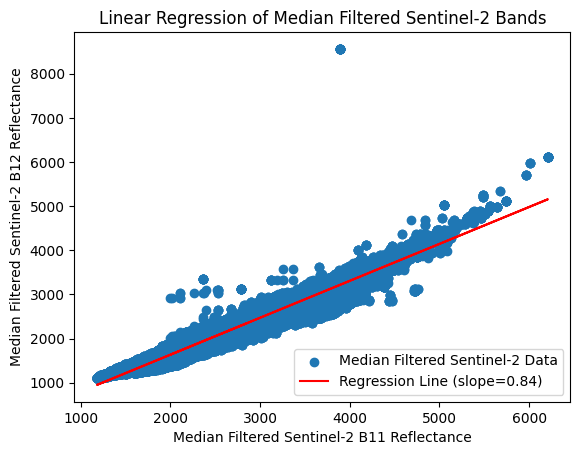

Slope: 0.84


In [65]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def perform_linear_regression(x_band, y_band):
    # Read the GeoTIFF file
    with rasterio.open("/home/hareeshrao/Methane/Pictures/Darwin_AC" + dateString + ".tif", 'r') as src:
        profile = src.profile
        width = src.width
        height = src.height

        # Read bands
        x_data = src.read(1)
        y_data = src.read(2)

        # Flatten the data
        x_data_flat = x_data.flatten()
        y_data_flat = y_data.flatten()

        # Plot the data points
        plt.scatter(x_data_flat, y_data_flat, label='Median Filtered Sentinel-2 Data')

        # Perform linear regression
        model = LinearRegression()
        x_data_flat = x_data_flat.reshape(-1, 1)
        model.fit(x_data_flat, y_data_flat)

        # Get the slope
        slope = model.coef_[0]
        intercept = model.intercept_

        # Plot the regression line
        plt.plot(x_data_flat, model.predict(x_data_flat), color='red', label=f'Regression Line (slope={slope:.2f})')

        # Add labels and legend
        plt.xlabel(f'Median Filtered Sentinel-2 {x_band} Reflectance')
        plt.ylabel(f'Median Filtered Sentinel-2 {y_band} Reflectance')
        plt.title('Linear Regression of Median Filtered Sentinel-2 Bands')
        plt.legend()

        # Show the plot
        plt.show()

        # Print the slope
        print(f'Slope: {slope:.2f}')

if __name__ == "__main__":
    # Specify the bands for linear regression
    band_x = 'B11'
    band_y = 'B12'

    # Perform linear regression on the median-filtered data
    perform_linear_regression(band_x, band_y)

# Chevron // 26/10/23
# Darwin // 26/10/23

## **Calculate Enhancement**

In [67]:
import ee
import folium
import geemap

# Initialize Google Earth Engine
ee.Initialize()

scaling_factor = 0.84
# Replace 'methane_band_name' and 'methane_free_band_name' with the actual band names
methane_band_name = 'B12'
methane_free_band_name = 'B11'

# Load the atmospherically corrected Sentinel-2 image
S2_ME = ee.Image(S2_MeF)

# Select the methane and methane-free bands
methane_band = S2_ME.select(methane_band_name)
methane_free_band = S2_ME.select(methane_free_band_name)

methane_times = methane_band.multiply(scaling_factor)
methane_ratio = methane_times.divide(methane_free_band)
methane_subtract = methane_ratio.subtract(1)

# Define a threshold for methane enhancement values
threshold = 0.5  # Adjust the threshold value as needed

# Create a mask for values above the threshold
mask = methane_subtract.gt(threshold)

# Display the Methane Enhancement on the Folium map
Map = geemap.Map()
Map.centerObject(S2_ME, zoom=12)

# Add layers to the Folium map with a mask applied
Map.add_ee_layer(methane_subtract.mask(mask), {
    'min': 0.33,
    'max': 0.6,  # Adjust the min and max values as needed
    'palette': ['purple', 'white', 'red']
}, 'High Methane Enhancement')

# Add layer control panel to the map
Map.addLayerControl()

# Display the map
display(Map)

Map(center=[-12.472883164138935, 130.50711081587085], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap
import rasterio
import os
import numpy as np
from scipy.ndimage import median_filter

# Function to perform median filtering on bands
def median_filter_bands(input_path, output_path, band_numbers, window_size):
    with rasterio.open(input_path, 'r+') as src:
        profile = src.profile
        width = src.width
        height = src.height

        # Read bands
        bands_data = [src.read(band) for band in band_numbers]

        # Stack the bands along a new axis
        stacked_bands = np.stack(bands_data, axis=-1)

        # Apply median filter to both bands simultaneously
        filtered_data = median_filter(stacked_bands, size=(window_size[0], window_size[1], 1))

        # Update profile for the output raster
        profile.update(dtype=rasterio.float32, count=len(band_numbers))

        # Save the filtered bands to a new GeoTIFF file
        with rasterio.open(output_path, 'w', **profile) as dst:
            for band_number, band_data in zip(band_numbers, np.rollaxis(filtered_data, -1)):
                dst.write(band_data.astype(rasterio.float32), band_number)

    print(f"Saved Median Data as: {output_path}")

if __name__ == "__main__":
    # Specify input Sentinel-2 data path
    input_path = "/home/hareeshrao/Methane/Pictures/Chevron_AC" + dateString + ".tif"

    # Specify output path for the median-filtered bands
    output_path = "/home/hareeshrao/Methane/Pictures/Chevron_AC_median.tif"

    # Band numbers for Sentinel-2: Band 11 and Band 12
    band_numbers = [2, 1]

    # Window size for median filtering
    window_size = (3, 3)  # Adjust as needed

    # Perform median filtering for Bands 11 and 12 simultaneously and save to a new GeoTIFF file
    median_filter_bands(input_path, output_path, band_numbers, window_size)

    # Authenticate to Earth Engine
    ee.Initialize()

    # Upload the GeoTIFF file to Earth Engine
    local_path = output_path
    asset_id = "users/your_username/path/Chevron_AC_median"  # Update with your own path
    task = ee.data.startIngestion(
        "create_upload_session", 
        {
            "name": asset_id,
            "bands": [{'id': '1'}, {'id': '2'}, {'id': '3'}],  # Adjust as needed based on the number of bands
            "tilesets": [{"sources": [{"uris": [local_path]}]}]
        }
    )

    print(f"Image upload task started: {asset_id}")
    print("You can check the task status in the Earth Engine Console.")

    # Load the median-filtered bands from Earth Engine using the asset ID
    median_filtered_image = ee.Image(asset_id)

    # Scaling factor
    scaling_factor = 0.87

    # Define band names for methane and methane-free bands
    methane_band_name = 'B12'
    methane_free_band_name = 'B11'

    # Select the methane and methane-free bands from the median-filtered image
    methane_band = median_filtered_image.select(methane_band_name)
    methane_free_band = median_filtered_image.select(methane_free_band_name)

    methane_times = methane_band.multiply(scaling_factor)
    methane_ratio = methane_times.divide(methane_free_band)
    methane_subtract = methane_ratio.subtract(1)

# Define a threshold for methane enhancement values
    threshold = 0.5  # Adjust the threshold value as needed

# Create a mask for values above the threshold
    mask = methane_subtract.gt(threshold)

# Display the Methane Enhancement on the Folium map
    Map = geemap.Map()
    Map.centerObject(S2_ME, zoom=12)

# Add layers to the Folium map with a mask applied
    Map.add_ee_layer(methane_subtract.mask(mask), {
        'min': 0.33,
        'max': 0.6,  # Adjust the min and max values as needed
        'palette': ['purple', 'white', 'red']
    }, 'High Methane Enhancement')

# Add layer control panel to the map
    Map.addLayerControl()

# Display the map
    display(Map)


##### Export pixel values

In [ ]:
# make sure to choose the pixels first by clicking on the plotting icon and place markers 
out_dir = os.path.join(os.path.expanduser('~'), 'Methane/Pixels')
out_csv = os.path.join(out_dir, 'points.csv')
out_shp = os.path.join(out_dir, 'points.shp')

Map.extract_values_to_points(out_shp)

In [ ]:
# To read shape file

import geopandas as gpd

# Specify the path to your shapefile (.shp) without the extension
shapefile_path = '/home/hareeshrao/Methane/Pixels/points.shp'
# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Print the GeoDataFrame
print(gdf)


# **Fractional Absorption Model**

In [ ]:
calculate something

## HITRAN

In [ ]:
from hapi import *
import pylab
import pandas

In [ ]:
data_CH4 = fetch_by_ids('CH4',[1,2], 4000, 6500)

In [ ]:
# open/state the folder in your database
db_begin('CH4')

In [ ]:
# commit changes made to database & save it
db_commit()

In [ ]:
describeTable('CH4')

In [ ]:
# calculate absorption coefficient using Lorentz
nu,coef_= absorptionCoefficient_Lorentz(SourceTables='CH4',HITRAN_units=False)
print('nu,coef:',coef)

In [ ]:
# calculate absorption coefficient using Voigt
nu,coef = absorptionCoefficient_Voigt(((6,1),),'CH4',OmegaStep=0.01,HITRAN_units=False,GammaL='gamma_air')
print('nu,coef:',coef)

In [ ]:
from pylab import plot
plot(nu,coef)

In [ ]:
# calculate absorption spectrum
nu,absorp = absorptionSpectrum(nu,coef)

# calculate transmittance spectrum
nu,trans = transmittanceSpectrum(nu,coef)

# calculate radiance spectrum
nu,radi = radianceSpectrum(nu,coef)

In [ ]:
print('nu,absorp:',absorp)
print('nu,trans:',trans)
print('nu,radi:',radi)

In [ ]:
ISO_ID

In [ ]:
# natural abundance
abundance(6, 1) # CH4

In [ ]:
# molecular mass
molecularMass(6, 1)

In [ ]:
# name of Hitran molecule
moleculeName(6)

In [ ]:
# ISO name
isotopologueName(6, 1)

##### Plotting Hitran

In [ ]:
from hapi import *
from pylab import show,plot,subplot,xlim,ylim,title,legend,xlabel,ylabel

In [ ]:
x,y = getStickXY('CH4')
plot(x,y)

In [ ]:
# Zooming in specific spectral region
plot(x,y,'.'); xlim([4200,4300]); show()

In [ ]:
getHelp(PROFILE_VOIGT)

In [ ]:
getHelp(PROFILE_LORENTZ)

In [ ]:
wn = arange(4100,4500,0.01) # get wavenumber range of interest
voi = PROFILE_VOIGT(4300,0.1,0.3,0.002,wn)[0] # calc Voigt
lor = PROFILE_LORENTZ(4300,0.3,0.002,wn) # calc Lorentz
diff = voi-lor # calc difference
subplot(2,1,1) # upper panel
plt.plot(wn, voi, 'red', label='Voigt')
plt.plot(wn, lor, 'blue', label='Lorentz')# plot both profiles
legend(['Voigt','Lorentz']) # show legend
title('Voigt and Lorentz profiles') # show title
subplot(2,1,2) # lower panel
plot(wn,diff) # plot difference
title('Voigt-Lorentz residual') # show title
show() # show all figures

In [ ]:
# Calculate Spectra
from numpy import arange
import math 

vc = 

# Calculate New
c = 3.0e8
T = 296
m = 16.04
k = 1.380649e-23
Na = 6.02214129e23
in_SQRT = 2*Na*k*T
div_kTm = in_SQRT/m
ln2 = math.log(2)
times = ln2 * div_kTm
SQRT = math.sqrt(times)
GammaD = nu_center*SQRT
#GammaD = nu_center*math.sqrt[math.log(2) * ((2*k*T)/(m))]
print("GammaD:", GammaD, "cm-1")

In [ ]:
w0 = 1000.
GammaD = 0.005
Gamma0 = 0.2
Gamma2 = 0.01 * Gamma0
Delta0 = 0.002
Delta2 = 0.001 * Delta0
nuVC = 0.2
eta = 0.5
Dw = 1.
ww = arange(w0-Dw, w0+Dw, 0.01)  # GRID WITH THE STEP 0.01 
l1 = PROFILE_HT(w0,GammaD,Gamma0,Gamma2,Delta0,Delta2,nuVC,eta,ww)[0]
# now l1 contains values of HT profile calculates on the grid ww
print("Value:", l1)

In [ ]:
getHelp(plotting)

In [ ]:
select('CH4', ParameterNames=('nu', 'sw'), Conditions=('between','nu',6245,6250))

In [ ]:
Cond = ('AND',('BETWEEN','nu',1600,1605),('>=','sw',4.0e-30))
select('CH4',Conditions=Cond, DestinationTableName='CH4_Hitran')

In [ ]:
#nu1 = getColumn('CH4','nu')
nu2,sw2 = getColumns('CH4',['nu','sw'])

In [ ]:
# SAVE FILE
select('CH4',File='CH4_Hitran.txt')

In [ ]:
import subprocess

repository_url = "https://github.com/jterwin/pytran.git"
local_directory = "pytran"  # or whatever director"y name you prefer

# Clone the repository
subprocess.run(["git", "clone", repository_url, local_directory])


##### Test Hitran Module